<a href="https://colab.research.google.com/github/Christelleelkhoury/AI-for-Med.Diagnos.-Prediction/blob/main/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - AI for Medical Diagnosis and Prediction | Week #4

In this notebook, we continue our analysis of the MIMIC-CXR dataset by training convolutional neural networks for pathology classification. The objective is to perform a benchmark analysis of several models to detect the presence of pathologies in chest x-rays.

In addition, we will train a segmentation model with a classification head. The objective is to see if the segmentation of relevant areas helps for pathology detection.

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)

<div class="alert alert-block alert-info">
<b>Your tasks are the following:</b>  <br>
- Load the dataset using the same train, validation and test splits as during the previous week <i>(Task 1)</i> <br>
- Implement one (or two) convolutional neural networks (pretrained) and fine-tune them on your dataset <i>(Task 2)</i> <br>
- Evaluate the performance of the models using appropriate metrics <i>(Task 3)</i> <br>
- Implement a segmentation network of your choice (pretrained) <i>(Task 4)</i> <br>
- Add a classification head in addition to the segmentation network and train it on your dataset <i>(Task 4*)</i> <br>
- Evaluate the performance of the model, save the results of both models in a csv file using various appropriate metrics <i>(Task 4)</i> <br>
- Save the models and comment on their performance on the validation set <i>(Task 5)</i> <br>
- Compute the performance of the best model on the test set <i>(Task 5*)</i> <br>
</div>

**[1]** Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2024). MIMIC-CXR Database (version 2.1.0). PhysioNet. [https://doi.org/10.13026/4jqj-jw95](https://doi.org/10.13026/4jqj-jw95).

**[2]** Johnson, A.E.W., Pollard, T.J., Berkowitz, S.J. et al. MIMIC-CXR, a de-identified publicly available database of chest radiographs with free-text reports. Sci Data 6, 317 (2019). [https://doi.org/10.1038/s41597-019-0322-0](https://doi.org/10.1038/s41597-019-0322-0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

!pip install pydicom
!python3.8 -m pip install opencv-python
import pydicom
import time
import cv2
from PIL import Image
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import tv_tensors
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.metrics import roc_auc_score, RocCurveDisplay, DetCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score
import random
import joblib

seed = 42
random.seed(seed)
np.random.seed(seed)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.2 MB/s eta 0:00:00
/bin/bash: line 1: python3.8: command not found


In [ ]:
DATA_PATH = './MIMIC-CXR-png'

Please run the following cell to download the .png dataset. Here, we will use the chest X-ray images and the labels extracted.

In [ ]:
!wget https://uni-bonn.sciebo.de/s/KrMiTk2X7sgBCwK/download/MIMIC-CXR-png.zip -O MIMIC-CXR-png.zip
!unzip MIMIC-CXR-png.zip -d ./

Streaming output truncated to the last 5000 lines.
   creating: ./MIMIC-CXR-png/segmentation/18061783/52119829/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/52119829/c3f7e5ef-b37abc31-841e861f-3773f7c6-cd79e0e0.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/52109079/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/52109079/f8532a91-2d34769b-7afcc3c2-132b6010-90eafdf3.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/53017596/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/53017596/fe88afe0-5db46aac-9b35164c-00001574-cbe3dd88.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/58867787/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/58867787/aafdfb59-2ef9d4e1-795db55d-41504c44-0e961995.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/51783178/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/51783178/e113e4a8-b00775ef-3373de4d-c3cc3ef4-7b51e532.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/54160003/
  inflating: ./MIMIC-CXR-png

In [ ]:
!wget https://uni-bonn.sciebo.de/s/WKK5myfPpcyEyeC/download/radiomics.csv -O radiomics.csv
!wget https://uni-bonn.sciebo.de/s/WgCFQEZW6HQdb4a/download/labels.csv -O labels.csv
!wget https://uni-bonn.sciebo.de/s/rmp3nCZ4Qi5LCw3/download/train_labels.csv -O train_labels.csv
!wget https://uni-bonn.sciebo.de/s/tKzZ2fp27PkTqQQ/download/test_labels.csv -O test_labels.csv

--2025-09-28 00:41:13--  https://uni-bonn.sciebo.de/s/WKK5myfPpcyEyeC/download/radiomics.csv
Resolving uni-bonn.sciebo.de (uni-bonn.sciebo.de)... 128.176.1.2
Connecting to uni-bonn.sciebo.de (uni-bonn.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1286877 (1.2M) [text/csv]
Saving to: ‘radiomics.csv’

radiomics.csv       100%[===================>]   1.23M  1.23MB/s    in 1.0s    

2025-09-28 00:41:15 (1.23 MB/s) - ‘radiomics.csv’ saved [1286877/1286877]

--2025-09-28 00:41:15--  https://uni-bonn.sciebo.de/s/WgCFQEZW6HQdb4a/download/labels.csv
Resolving uni-bonn.sciebo.de (uni-bonn.sciebo.de)... 128.176.1.2
Connecting to uni-bonn.sciebo.de (uni-bonn.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63894 (62K) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]  62.40K   192KB/s    in 0.3s    

2025-09-28 00:41:16 (192 KB/s) - ‘labels.csv’ saved [63894/63894]

-

In [ ]:
labels_df = pd.read_csv('labels.csv')

In [ ]:
labels_df

,labels_encoded,pathology,subject_id,study_id,dicom_id
0,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743
1,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee
2,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b
3,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18000379,51568340,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb
4,[1 0 0 0 0 0 0 0 0 0 0 0 0 1],1,18000379,51817182,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2
...,...,...,...,...,...
667,[1 0 0 1 0 0 0 0 0 0 0 0 0 0],1,18984616,55967331,5a77c3a2-d0f94e09-94eb621f-f66d487c-947ee67c
668,[1 0 0 1 0 0 0 0 0 0 0 0 0 0],1,18984616,58877483,c634a832-7e512367-badf40b4-517e2ea1-6683444e
669,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18995100,52470883,f56ccfaa-99efa5a1-14c02d21-c4eee720-023e4ec4
670,[1 0 0 1 0 1 0 1 0 0 0 0 0 0],1,18995100,57897996,572a3a1a-04167bad-656a0790-72d7d94c-6138230d


reduce to one label per patient, with `df['pathology']` 0/1 and as subject_id may have multiple rows, if a patient has any positive row, label them positive:

In [ ]:
df = pd.read_csv(f'radiomics.csv')
patient_label = (
    df
    .groupby('subject_id')['pathology']
    .max()          # max of 0/1 gives 1 if any row is positive
    .astype(int)
)
patients = patient_label.index.values      # array of subject_ids
labels   = patient_label.values

## Task 1 - Dataset
* Retrieve the train and test sets of patients used during week 3. Note that this is important to re-use the same splits for a fair comparison.
* Complete the `ClassificationDataset` class: you should be able to get images and corresponding labels using the dataframe and image directory path.
* Complete the `SegmentationDataset` class: you should be able to get images, corresponding masks and labels using the dataframe, image directory path and mask directory path.
* Split the train dataset to have a validation set for hyperparameter optimization and training followup.

In [ ]:
patient_train, patient_test = train_test_split(
    patients,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

# build train/test DataFrames by filtering on subject_id
train_df = df[df['subject_id'].isin(patient_train)].reset_index(drop=True)
test_df  = df[df['subject_id'].isin(patient_test)].reset_index(drop=True)

# Verify prevalence
print("Overall prevalence: ", df['pathology'].mean())
print("Train prevalence:   ", train_df['pathology'].mean())
print("Test prevalence:    ", test_df['pathology'].mean())

Overall prevalence:  0.5082212257100149
Train prevalence:    0.5409090909090909
Test prevalence:     0.44541484716157204


In [ ]:
train_df['pathology'].value_counts()

,count
pathology,
1,238
0,202


In [ ]:
train_patients = train_df['subject_id'].unique()
train_labels   = patient_label.loc[train_patients].values  # pathology 0/1 per patient

# Split off a % of the train‐candidates as validation
patient_train_final, patient_val = train_test_split(
    train_patients,
    test_size=0.20,        # 20% of train_df
    random_state=42,
    stratify=train_labels
)

# Build your final DataFrames
train_df = df[df['subject_id'].isin(patient_train_final)].reset_index(drop=True)
val_df         = df[df['subject_id'].isin(patient_val)].reset_index(drop=True)
test_df        = test_df.copy()  # unchanged

# Check prevalences
print("Overall prevalence: ", df['pathology'].mean())
print(" Final train prev:  ", train_df['pathology'].mean())
print(" Validation prev:   ", val_df['pathology'].mean())
print(" Test prev:         ", test_df['pathology'].mean())

Overall prevalence:  0.5082212257100149
 Final train prev:   0.5318471337579618
 Validation prev:    0.5634920634920635
 Test prev:          0.44541484716157204


In [ ]:
# Construct the full expected PNG path for each row
image_dir = './MIMIC-CXR-png/files-png'
train_df['img_path'] = train_df.apply(lambda r: os.path.join(image_dir,f"p{r.subject_id}",f"s{r.study_id}",f"{r.dicom_id}.png"),axis=1);train_df.reset_index(drop=True,inplace=True)
val_df['img_path'] = val_df.apply(lambda r: os.path.join(image_dir,f"p{r.subject_id}",f"s{r.study_id}",f"{r.dicom_id}.png"),axis=1);val_df.reset_index(drop=True, inplace=True)
test_df['img_path'] = test_df.apply(lambda r: os.path.join(image_dir,f"p{r.subject_id}",f"s{r.study_id}",f"{r.dicom_id}.png"),axis=1);test_df.reset_index(drop=True,inplace=True)

Let's double check that the paths and the .png files actually exist in the filesystem. This is important to verify that the dataset was downloaded and extracted correctly and that there are no corrupted files or conversion errors from DICOM to PNG.

In [ ]:
# Function to check existence and drop missing images
def check_and_drop_missing_images(df, name):
    exists_mask = df['img_path'].map(os.path.exists)
    if not exists_mask.all():
        missing_count = (~exists_mask).sum()
        print(f"Dropping {missing_count} missing images from {name}:")
        for p in df.loc[~exists_mask, 'img_path'].head(5):
            print("    ", p)
        df = df[exists_mask].reset_index(drop=True)
    else:
        print(f"All images in {name} exist.")
    return df

# Apply the function to train_df, val_df, and test_df
train_df = check_and_drop_missing_images(train_df, "train_df")
val_df = check_and_drop_missing_images(val_df, "val_df")
test_df = check_and_drop_missing_images(test_df, "test_df")

All images in train_df exist.
All images in val_df exist.
All images in test_df exist.


In [ ]:
print("Train pathology value counts:\n", train_df['pathology'].value_counts())
print("\nValidation pathology value counts:\n", val_df['pathology'].value_counts())
print("\nTest pathology value counts:\n", test_df['pathology'].value_counts())

Train pathology value counts:
 pathology
1    167
0    147
Name: count, dtype: int64

Validation pathology value counts:
 pathology
1    71
0    55
Name: count, dtype: int64

Test pathology value counts:
 pathology
0    127
1    102
Name: count, dtype: int64


In [ ]:
from PIL import ImageOps
class ClassificationDataset(Dataset):
    def __init__(self, dataframe, image_dir=None, train=False, image_size=380, channels=3):
        super().__init__()
        # assume dataframe has already been filtered and contains 'img_path' and 'pathology'
        self.image_paths = dataframe['img_path'].tolist()
        self.labels      = dataframe['pathology'].tolist()
        self.size        = image_size
        if channels== 3:
          self.mean = np.array([0.485, 0.456, 0.406])
          self.std  = np.array([0.229, 0.224, 0.225])
        elif channels==1:
          self.mean = np.array([0.5])
          self.std  = np.array([0.2])

      #  # build transforms
        if train:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.RandomRotation(degrees=(-20, 20)),
                torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
                torchvision.transforms.RandomResizedCrop(self.size, scale=(0.4, 0.6),ratio=(1.0, 1.0)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std),
            ])
        else:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.Resize((512, 512)),
                torchvision.transforms.CenterCrop((self.size, self.size)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std)
            ])

    def __getitem__(self, index: int):
        path   = self.image_paths[index]
        image  = Image.open(path).convert('L')
        image = self.transforms_img(image)
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image, target

    def __len__(self) -> int:
        return len(self.image_paths)

In [ ]:
train_dataset_cls = ClassificationDataset(
    train_df,
    f'{DATA_PATH}/files-png/',
    train = True
)

val_dataset_cls = ClassificationDataset(
    val_df,
    f'{DATA_PATH}/files-png/'
)

Visualize a few examples of your `train_dataloader` and `val_loader`


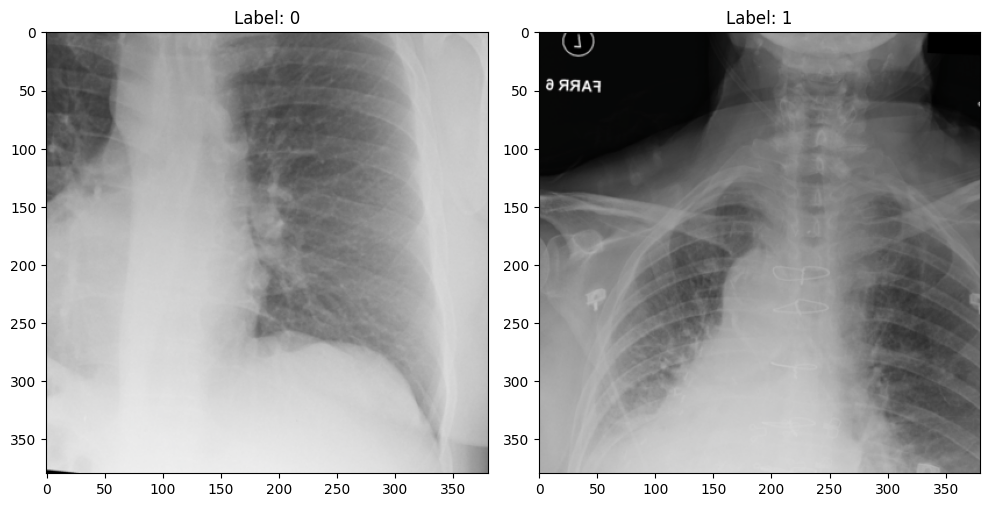

In [ ]:
train_dataloader = DataLoader(train_dataset_cls, batch_size=32, shuffle=True)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
for X, y in train_dataloader:
    # find first label==0
    first_zero = (y == 0).nonzero(as_tuple=True)[0][0].item()
    img = X[first_zero].cpu().numpy()           # C x H x W
    img = np.transpose(img, (1, 2, 0))           # H x W x C

    # undo normalization
    img = img * std + mean
    img = np.clip(img, 0, 1)

    ax[0].imshow(img)
    ax[0].set_title('Label: ' + str(y[first_zero].item()))

    # find first label==1 (if exists), then break
    ones = (y == 1).nonzero(as_tuple=True)[0]
    if ones.numel() > 0:
        first_one = ones[0].item()
        img = X[first_one].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))

        # undo normalization
        img = img * std + mean
        img = np.clip(img, 0, 1)

        ax[1].imshow(img, cmap='gray')
        ax[1].set_title('Label: ' + str(y[first_one].item()))
        break

plt.tight_layout()
plt.show()


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, dataframe, image_dir, mask_dir, trs=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.df = dataframe

        self.image_ids = self.df['dicom_id'].tolist()
        self.image_paths = dataframe['img_path'].tolist()
        self.study_ids = self.df['study_id'].tolist()
        self.subject_ids = self.df['subject_id'].tolist()
        self.labels = dataframe['pathology'].tolist()

        self.size = 256
        self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Resize((self.size, self.size)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,), (0.2,))
            ])

        self.transforms_mask = transforms.Compose([
            torchvision.transforms.Resize((self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST),
            torchvision.transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        study_id = self.study_ids[index]
        subject_id = self.subject_ids[index]
        target = self.labels[index]

        path   = self.image_paths[index]
        image  = Image.open(path).convert('L')
        image = self.transforms_img(image)

        target = torch.tensor(target)

        mask_path = f'{self.mask_dir}/{subject_id}/{study_id}/{image_id}.png'
        mask = Image.open(mask_path)
        mask = self.transforms_mask(mask)

        return image, mask, target

In [ ]:
train_dataset_seg = SegmentationDataset(
    train_df,
    f'{DATA_PATH}/files-png',
    f'{DATA_PATH}/segmentation'
)

val_dataset_seg = SegmentationDataset(
    val_df,
    f'{DATA_PATH}/files-png',
    f'{DATA_PATH}/segmentation'
)

test_dataset_seg = SegmentationDataset(
    test_df,
    f'{DATA_PATH}/files-png',
    f'{DATA_PATH}/segmentation'
)

## Task 2 - Classification
* Implement a Convolutional Neural Network for pathology classification. You can choose your preferred one among those explored during the lectures.
* Complete the training and validation loop, and train the model on the training set.
* (Optionally) Optimize hyperparameters or model architecture using this validation set.

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_loop_cls(dataloader, model, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        # Compute prediction and loss
        logits = model(X)
        loss = loss_fn(logits, y)
        # Backpropagation
        loss.backward()
        optimizer.step()

        # accumulate
        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == y).sum().item()
        running_total += y.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    print(f"Train → Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    # return model, epoch_loss, epoch_acc
    return model


def val_loop_cls(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == y).sum().item()
            running_total += y.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    print(f" Val  → Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}\n")
    # return epoch_loss, epoch_acc
    return epoch_acc

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, efficientnet_b4, EfficientNet_B4_Weights

learning_rate = 3e-4
batch_size = 6
epochs = 20

model_cls = efficientnet_b4(weights=EfficientNet_B4_Weights)
model_cls.classifier[1] = nn.Sequential(
    # nn.Dropout(0.3),
    nn.Linear(1792, 2)
)

train_dataloader = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_cls, batch_size=batch_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cls.parameters(), lr=learning_rate, weight_decay=1e-4) # torch.optim.SGD(model_enb0.parameters(), lr = learning_rate)#
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

model_cls.to(device)
loss_fn.to(device)

s = time.process_time() # start time

best_acc = 0
best_model = None

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_cls = train_loop_cls(train_dataloader, model_cls, loss_fn, optimizer, device)
    lr_scheduler.step()
    test_acc = val_loop_cls(val_dataloader, model_cls, loss_fn, device)

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model_cls

print("Done!")

torch.save(best_model.state_dict(), './efficientnetb4-pathology-cxr2.pth')

e = time.process_time() # end time
print(e - s, "seconds")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 116MB/s]


Epoch 1
-------------------------------
Train → Loss: 0.6732, Acc: 0.5924
 Val  → Loss: 0.6346, Acc: 0.6667

Epoch 2
-------------------------------
Train → Loss: 0.5993, Acc: 0.7102
 Val  → Loss: 0.6169, Acc: 0.6111

Epoch 3
-------------------------------
Train → Loss: 0.5356, Acc: 0.7261
 Val  → Loss: 0.5729, Acc: 0.7143

Epoch 4
-------------------------------
Train → Loss: 0.5001, Acc: 0.7580
 Val  → Loss: 0.5694, Acc: 0.7222

Epoch 5
-------------------------------
Train → Loss: 0.4720, Acc: 0.7866
 Val  → Loss: 0.5785, Acc: 0.6905

Epoch 6
-------------------------------
Train → Loss: 0.4188, Acc: 0.8376
 Val  → Loss: 0.6403, Acc: 0.7143

Epoch 7
-------------------------------
Train → Loss: 0.3918, Acc: 0.8185
 Val  → Loss: 0.7044, Acc: 0.6746

Epoch 8
-------------------------------
Train → Loss: 0.3290, Acc: 0.8471
 Val  → Loss: 0.7274, Acc: 0.6746

Epoch 9
-------------------------------
Train → Loss: 0.2898, Acc: 0.8790
 Val  → Loss: 0.7448, Acc: 0.6667

Epoch 10
----------

<div class="alert alert-block alert-success">
<b>Model convergence:</b> The training loss decreases steadily over epochs, indicating that the model is effectively learning from the data. This suggests the chosen hyperparameters (learning rate, batch size, etc.) are well-suited to the task.

<b>Overfitting:</b> If there's a growing gap between training and validation loss, this may indicate overfitting — the model is memorizing the training data but generalizing poorly. Regularization techniques such as dropout, weight decay, data augmentation, or early stopping may be necessary.

<b>Class imbalance:</b> If the dataset contains far fewer positive cases (e.g., pneumonia), learning can become biased or unstable. Class weighting in the loss function or balanced sampling strategies can help mitigate this.

<b>Stability:</b> A highly unstable or noisy loss curve could indicate that the learning rate is too high or the batch size is too small. Conversely, a flat or stagnant curve might point to an overly conservative learning rate or insufficient learning capacity.
</div>

## Task 3 - Segmentation + Classification
* Implement a Convolutional Neural Network for segmentation. Add a classification head on top of it to perform pathology classification.
* Train the model, and observe the training and validation loss across epochs.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, num_classes_cls=2, in_channels=3, out_channels=1): # UNet segmentation output is typically 1 channel for binary mask
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.MaxPool2d(2)
        self.classifier = nn.Linear(512, num_classes_cls)

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def encode(self, x):
        # Encoder
        self.e1 = self.enc1(x)
        self.e2 = self.enc2(F.max_pool2d(self.e1, 2))
        self.e3 = self.enc3(F.max_pool2d(self.e2, 2))
        self.b = self.bottleneck(F.max_pool2d(self.e3, 2))

        return self.b

    def classify(self, b):
        # Classification
        cls_feat = self.avgpool(b).view(b.size(0), -1)
        class_logits = self.classifier(cls_feat)

        return class_logits

    def decode(self, b):
        # Decoder
        self.d3 = self.dec3(torch.cat([F.interpolate(b, scale_factor=2, mode='bilinear', align_corners=True), self.e3], dim=1))
        self.d2 = self.dec2(torch.cat([F.interpolate(self.d3, scale_factor=2, mode='bilinear', align_corners=True), self.e2], dim=1))
        self.d1 = self.dec1(torch.cat([F.interpolate(self.d2, scale_factor=2, mode='bilinear', align_corners=True), self.e1], dim=1))

        out = self.final(self.d1)

        return out

    def forward(self, x):
        b = self.encode(x)

        cls = self.classify(b)
        seg = self.decode(b)

        return cls, seg

In [ ]:
def train_loop_seg(model, dataloader, optimizer, criterion_seg, criterion_cls, device):
    model.train()
    total_loss = 0.0

    for images, masks, targets in dataloader:
        optimizer.zero_grad()
        images, masks, targets = images.to(device), masks.to(device), targets.to(device)

        out_cls, out_seg = model(images)
        # if cls head produces raw logits for binary, use sigmoid; for multi-class use softmax+CrossEntropy
        probs_cls = torch.sigmoid(out_cls)

        loss = 0.2 * criterion_seg(out_seg, masks) + 0.8 * criterion_cls(probs_cls, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Train Loss: {avg_loss:.7f}')
    return model

def val_loop_seg(model, dataloader, criterion_seg, criterion_cls, device):
    model.eval()
    total_loss_cls = 0.0
    total_loss_seg = 0.0
    correct = 0
    size = len(dataloader.dataset)

    with torch.no_grad():
        for images, masks, targets in dataloader:
            images, masks, targets = images.to(device), masks.to(device), targets.to(device)

            out_cls, out_seg = model(images)
            probs_cls = torch.sigmoid(out_cls)

            loss_cls = criterion_cls(probs_cls, targets)
            loss_seg = criterion_seg(out_seg, masks)

            total_loss_cls += loss_cls.item()
            total_loss_seg += loss_seg.item()
            # for binary cls: threshold at 0.5 instead of argmax
            # preds = (probs_cls > 0.5).long().squeeze()
            # correct += (preds == targets).sum().item()

            preds      = probs_cls.argmax(1)            # pick the larger “probability” channel
            correct   += (preds == targets).sum().item()

    avg_cls = total_loss_cls / len(dataloader)
    avg_seg = total_loss_seg / len(dataloader)
    accuracy = correct / size * 100

    print(
        f'Validation — '
        f'Cls Loss: {avg_cls:.7f}  '
        f'Seg Loss: {avg_seg:.7f}  '
        f'Accuracy: {accuracy:.2f}%'
    )
    return avg_cls, avg_seg, accuracy


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

learning_rate = 1e-3
batch_size = 8
epochs = 100

train_dataset_seg = SegmentationDataset(
    train_df,
    f'{DATA_PATH}/files-png',
    f'{DATA_PATH}/segmentation'
)

val_dataset_seg = SegmentationDataset(
    val_df,
    f'{DATA_PATH}/files-png',
    f'{DATA_PATH}/segmentation'
)

model = UNet(2,1,1)

# Define loss function and optimizer
criterion_seg = nn.BCEWithLogitsLoss()
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_dataset_seg, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset_seg, batch_size=1, num_workers=4, pin_memory=True)

model.to(device)
best_loss = 100
best_model = None

val_losses_cls, val_losses_seg,  val_accuracies   = [], [], []
for t in range(epochs):
    print(f"-------------------------------\nEpoch {t+1}")
    model = train_loop_seg(model, train_dataloader, optimizer, criterion_seg, criterion_cls, device)
    loss_cls, loss_seg, val_acc = val_loop_seg(model, val_dataloader, criterion_seg, criterion_cls, device)
    if loss_cls < best_loss:
        best_loss=loss_cls
        best_model = model
    val_losses_cls.append(loss_cls)
    val_losses_seg.append(loss_seg)
    val_accuracies.append(val_acc)

print("Done!")
torch.save(best_model.state_dict(), 'unet_seg_cls_pathology_cxr2.pth')

-------------------------------
Epoch 1
Train Loss: 0.6860559
Validation — Cls Loss: 0.6923934  Seg Loss: 0.5642238  Accuracy: 56.35%
-------------------------------
Epoch 2
Train Loss: 0.6713868
Validation — Cls Loss: 0.6923172  Seg Loss: 0.6018221  Accuracy: 56.35%
-------------------------------
Epoch 3
Train Loss: 0.6716247
Validation — Cls Loss: 0.6946538  Seg Loss: 0.6036796  Accuracy: 43.65%
-------------------------------
Epoch 4
Train Loss: 0.6705320
Validation — Cls Loss: 0.6917694  Seg Loss: 0.6149141  Accuracy: 56.35%
-------------------------------
Epoch 5
Train Loss: 0.6562918
Validation — Cls Loss: 0.6918568  Seg Loss: 0.4924313  Accuracy: 56.35%
-------------------------------
Epoch 6
Train Loss: 0.6371331
Validation — Cls Loss: 0.6908934  Seg Loss: 0.4058765  Accuracy: 56.35%
-------------------------------
Epoch 7
Train Loss: 0.6280209
Validation — Cls Loss: 0.6868632  Seg Loss: 0.3798919  Accuracy: 56.35%
-------------------------------
Epoch 8
Train Loss: 0.6266625


<div class="alert alert-block alert-success">
While a standard CNN (like EfficientNet) learns global features for classification, adding a segmentation head encourages the model to also learn spatially localized features — which may be more relevant for pathology detection in medical imaging.<br><br>

The segmentation output provides visual evidence of the model's decision, which enhances transparency and clinical interpretability — something standalone classifiers often lack.<br>

Depending on the dataset, the segmentation + classification model may slightly improve classification performance (e.g., higher recall), especially when the task requires precise spatial understanding (e.g., detecting a small lesion).<br>

</div>

## Task 4 - Evaluation
* Implement a few evaluation metrics to compare the performance of the two networks. Remember that the objective is pathology detection, so you must take into account the importance of false positives and false negatives in that context.
* Run inference of the two models on the test set and print a table with the metrics to compare.

Download the weights:

In [ ]:
!curl https://uni-bonn.sciebo.de/s/ndLtjn4tqqcnfN3/download/unet_seg_cls_pathology_cxr.pth -o unet_seg_cls_pathology_cxr.pth
!curl https://uni-bonn.sciebo.de/s/Hfapn7KK2KwHoBM/download/efficientnetb4-pathology-cxr2.pth -o efficientnetb4-pathology-cxr.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.7M  100 29.7M    0     0  8931k      0  0:00:03  0:00:03 --:--:-- 8929k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.6M  100 67.6M    0     0  14.5M      0  0:00:04  0:00:04 --:--:-- 17.3M


Model EfficientNet-B4: 
Accuracy: 0.6943231441048034 
F1-score: 0.6634615384615384 
Recall: 0.6764705882352942 
Precision: 0.6509433962264151 
AUC: 0.7636251350934075
Model UNet: 
Accuracy: 0.6069868995633187 
F1-score: 0.5544554455445545 
Recall: 0.5490196078431373 
Precision: 0.56 
AUC: 0.6477535896248264


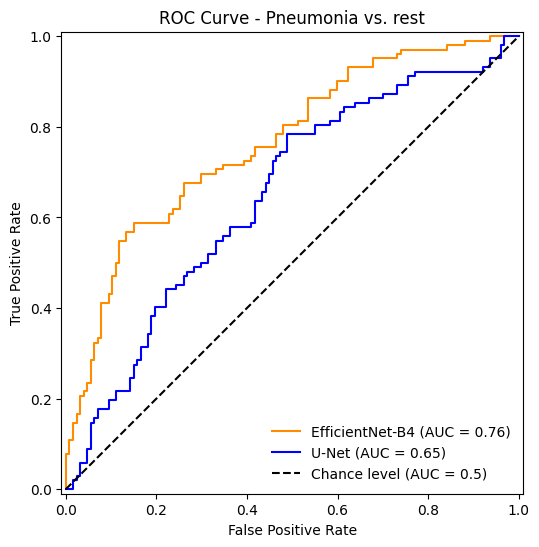

In [ ]:
# Evaluation function
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, efficientnet_b4, EfficientNet_B4_Weights

def evaluate_model(model, dataloader, device, model_name):
    model.eval()
    model.to(device)

    preds_list = []
    probs_list = []
    label_list = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            if model_name == 'EfficientNet-B4':
                out = model(X)
            elif model_name == 'UNet':
                out, _ = model(X)
            else:
                raise ValueError("Invalid model_name")


            probs = nn.functional.softmax(out, dim=1)  # use softmax for multi-logit outputs
            preds = probs.argmax(dim=1)

            probs_list.append(probs[:, 1].item())  # probability for class 1
            label_list.append(y.detach().cpu().numpy().item()) # ensure label is a single item
            preds_list.append(preds.item())


    # Calculate metrics
    accuracy = accuracy_score(label_list, preds_list)
    f1 = f1_score(label_list, preds_list)
    recall = recall_score(label_list, preds_list)
    precision = precision_score(label_list, preds_list)
    auc = roc_auc_score(label_list, probs_list)


    print(
        f'Model {model_name}:',
        '\nAccuracy:', accuracy,
        '\nF1-score:', f1,
        '\nRecall:', recall,
        '\nPrecision:', precision,
        '\nAUC:', auc
    )
    return label_list, probs_list

# Load the trained models
model_enb4 = efficientnet_b4(weights=EfficientNet_B4_Weights)
model_enb4.classifier[1] = nn.Sequential(
    nn.Linear(1792, 2)
)
model_enb4.load_state_dict(torch.load('./efficientnetb4-pathology-cxr.pth'))

model_unet = UNet(2,1,1)
model_unet.load_state_dict(torch.load('./unet_seg_cls_pathology_cxr.pth'))

# Create test dataloaders
test_dataset_cls_enb4 = ClassificationDataset(
    test_df,
    f'{DATA_PATH}/files-png',
    train=False,
    image_size=380,
    channels=3
)

test_dataset_cls_unet = ClassificationDataset(
    test_df,
    f'{DATA_PATH}/files-png/',
    train=False,
    image_size=256,
    channels=1
)

test_dataloader_enb4 = DataLoader(test_dataset_cls_enb4, batch_size=1)
test_dataloader_unet = DataLoader(test_dataset_cls_unet, batch_size=1)

# Evaluate models and get true labels and predicted probabilities
label_list_enb4, probs_list_enb4 = evaluate_model(model_enb4, test_dataloader_enb4, device, 'EfficientNet-B4')
label_list_unet, probs_list_unet = evaluate_model(model_unet, test_dataloader_unet, device, 'UNet')

# Plot ROC curves
plt.figure(figsize=(8, 6))

display_enb4 = RocCurveDisplay.from_predictions(
    label_list_enb4,
    probs_list_enb4,
    name="EfficientNet-B4",
    color="darkorange",
    ax=plt.gca()
)

display_unet = RocCurveDisplay.from_predictions(
    label_list_unet,
    probs_list_unet,
    name="U-Net",
    color="blue",
    plot_chance_level=True,
    ax=plt.gca()
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Pneumonia vs. rest")
plt.legend(frameon=False)
plt.show()


Loading the models from Project week 3 for comparison



In [ ]:
X_train = train_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology','img_path'], axis=1)
y_train = train_df['pathology']

X_test = test_df.drop(['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'labels_encoded', 'pathology','img_path'], axis=1)
y_test = test_df['pathology']

Retrieve previous models

In [ ]:
!curl https://uni-bonn.sciebo.de/s/NFrr42TJbWceBZZ/download/previous_models.zip -o previous_models.zip
!unzip previous_models.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  540k  100  540k    0     0   283k      0  0:00:01  0:00:01 --:--:--  283k
Archive:  previous_models.zip
  inflating: best_model_logistic_regression.pkl  
  inflating: best_model_nearest_neighbors.pkl  
  inflating: best_model_random_forest.pkl  
  inflating: best_model_smote_logistic_regression.pkl  
  inflating: best_model_smote_nearest_neighbors.pkl  
  inflating: best_model_smote_random_forest.pkl  


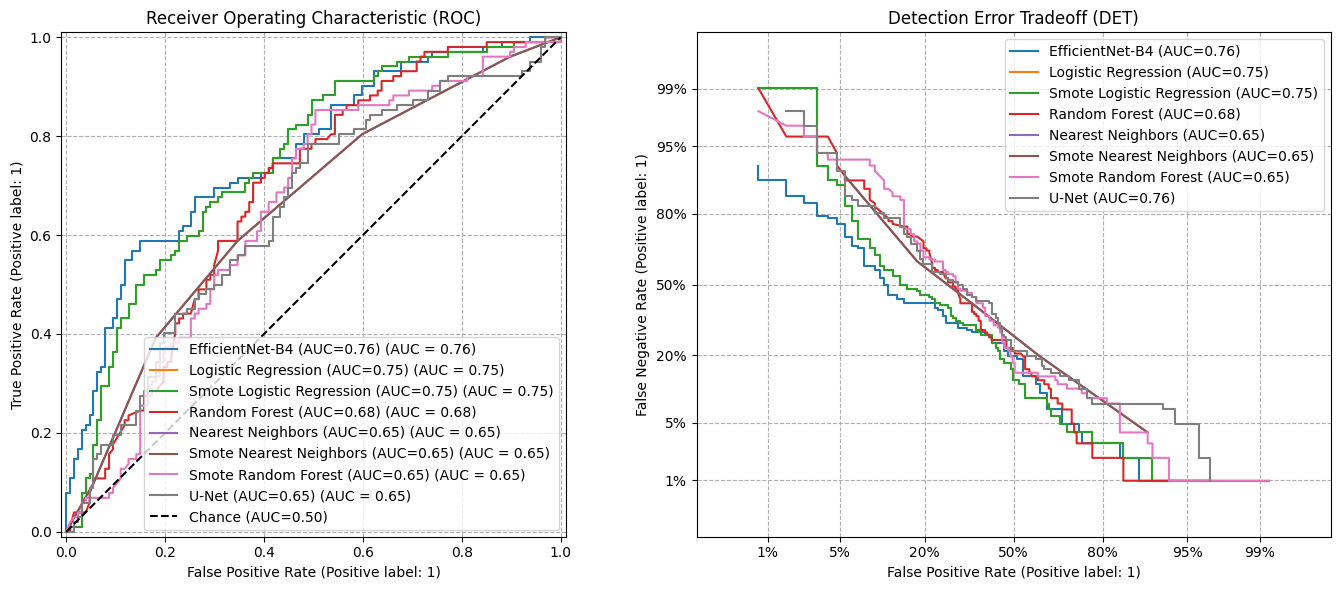

In [ ]:
def get_model_auc(model_filepath, X_test, y_test):
    mdl = joblib.load(model_filepath)
    # try predict_proba, else decision_function
    if hasattr(mdl, "predict_proba"):
        y_score = mdl.predict_proba(X_test)[:, 1]
    else:
        y_score = mdl.decision_function(X_test)
    return roc_auc_score(y_test, y_score)

# 1) gather AUCs
path = "./"
model_files = [f for f in os.listdir(path)
               if f.startswith("best_model_") and f.endswith(".pkl")]

model_aucs = []
for mf in model_files:
    auc = get_model_auc(path + mf, X_test, y_test)
    model_aucs.append((mf, auc))

# 2) sort descending by AUC
model_aucs.sort(key=lambda x: x[1], reverse=True)

# 3) now plot in that order
fig, (ax_roc, ax_det) = plt.subplots(1, 2, figsize=(14, 6))

# EfficientNet‑B4
auc_enb4 = roc_auc_score(label_list_enb4, probs_list_enb4)
RocCurveDisplay.from_predictions(
    label_list_enb4,
    probs_list_enb4,
    name=f"EfficientNet‑B4 (AUC={auc_enb4:.2f})",
    ax=ax_roc,
    plot_chance_level=False
)
DetCurveDisplay.from_predictions(
    label_list_enb4,
    probs_list_enb4,
    name=f"EfficientNet‑B4 (AUC={auc_enb4:.2f})",
    ax=ax_det
)

for mf, auc in model_aucs:
    mdl = joblib.load(path + mf)
    name = (os.path.basename(mf)
              .replace("best_model_", "")
              .replace(".pkl", "")
              .replace("_", " ")
              .title())
    label = f"{name} (AUC={auc:.2f})"

    # ROC
    RocCurveDisplay.from_estimator(
        mdl, X_test, y_test,
        name=label, ax=ax_roc,
        plot_chance_level=False  # we'll add that line ourselves
    )
    # DET
    DetCurveDisplay.from_estimator(
        mdl, X_test, y_test,
        name=label, ax=ax_det
    )
# U‑Net
auc_unet = roc_auc_score(label_list_unet, probs_list_unet)
RocCurveDisplay.from_predictions(
    label_list_unet,
    probs_list_unet,
    name=f"U‑Net (AUC={auc_unet:.2f})",
    ax=ax_roc,
    plot_chance_level=False
)
DetCurveDisplay.from_predictions(
    label_list_unet,
    probs_list_unet,
    name=f"U‑Net (AUC={auc_enb4:.2f})",
    ax=ax_det
)
# add the chance line last
ax_roc.plot([0, 1], [0, 1], "--", color="black", label="Chance (AUC=0.50)")

# titles & grids
ax_roc.set_title("Receiver Operating Characteristic (ROC)")
ax_det.set_title("Detection Error Tradeoff (DET)")
ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

# legends
ax_roc.legend(loc="lower right")
ax_det.legend(loc="upper right")

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
The ROC analysis shows that the EfficientNet‑B4 classifier (orange line) achieves superior separability between pneumonia and non‑pneumonia cases (AUC = 0.76), compared to the U‑Net–based approach (blue line, AUC = 0.65) and the chance baseline (dashed, AUC = 0.50).<br><br>

The EfficientNet‑B4 curve climbs steeply toward the top‑left corner, reflecting both high sensitivity and specificity. The gap between the two model curves underscores the benefit of using a dedicated classification backbone rather than a segmentation network for this task.<br><br>

<b>Clinical interpretation</b><br>
With an AUC of 0.76 suggests that we are up to something with the EfficientNet‑B4, and further improvements could serve as a decision‑support tool to flag potential pneumonia cases on chest X‑rays, especially given its strong recall profile (minimizing missed cases). Before deployment, however, further external validation and bias analyses (e.g., performance across age, sex, or imaging equipment) are essential to ensure robustness and fairness.<br><br>

Future work should include detailed error analysis (for example, via Grad‑CAM heatmaps) to verify that the model is focusing on clinically relevant regions rather than spurious artifacts.
</div>
